In [3]:
### Distribution des jeux vidéos dans le temps, relatif au jeux vidéos
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import pprint
import csv
import sys
from importlib import reload
import sqlite3 as sql

import time
import datetime
from dateutil import parser

from shutil import copyfile

In [5]:
sys.path.insert(0, '..')
sys.path.insert(0, '../..')
import sparql_functions as spqf

In [13]:
endpoint = "https://ag1zhv7l0xefmdtk.allegrograph.cloud/repositories/Esport"

query = """
PREFIX wd:      <http://www.wikidata.org/entity/>
PREFIX wdt:     <http://www.wikidata.org/prop/direct/>
PREFIX rdfs:    <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd:  <http://www.w3.org/2001/XMLSchema#>


SELECT  ?item 
        (SAMPLE(STR(?itemLabel)) as ?itemLabel) 
        (MAX(?birthDate) as ?birthDate)  
        (MAX(?country) as ?country)
        ( GROUP_CONCAT(DISTINCT ?game; separator=", ") AS ?games )
WHERE {
    GRAPH <https://github.com/enaxorb/esportplayers/blob/main/graphs/wikidata-imported-data.md> {        
    ?item wdt:P569 ?birthDate;
        wdt:P27 ?country;
        wdt:P2416 ?game;

    OPTIONAL {?item rdfs:label ?itemLabel .}
  }  
}
GROUP BY ?item
"""

In [12]:
qr = spqf.get_json_sparql_result(endpoint, query)

In [16]:
result = spqf.sparql_result_to_list(qr)

In [17]:
df_r = pd.DataFrame(result)
df_r.columns = ['personUri','itemLabel','birthYear','country','game']
df_r.head()

,personUri,itemLabel,birthYear,country,game
0,http://www.wikidata.org/entity/Q117453830,Raza,1996-01-21T00:00:00Z,http://www.wikidata.org/entity/Q843,http://www.wikidata.org/entity/Q18142874
1,http://www.wikidata.org/entity/Q85885109,Ziv,1994-01-01T00:00:00Z,http://www.wikidata.org/entity/Q865,http://www.wikidata.org/entity/Q223341
2,http://www.wikidata.org/entity/Q2018204,Olav Undheim,1986-07-11T00:00:00Z,http://www.wikidata.org/entity/Q20,http://www.wikidata.org/entity/Q207948
3,http://www.wikidata.org/entity/Q23008035,Aui_2000,1992-10-02T00:00:00Z,http://www.wikidata.org/entity/Q16,http://www.wikidata.org/entity/Q771541
4,http://www.wikidata.org/entity/Q22974862,Jeon Young Soo,1987-09-22T00:00:00Z,http://www.wikidata.org/entity/Q884,"http://www.wikidata.org/entity/Q840409, http:/..."


[1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005]
per_5
[1970, 1975)      2
[1975, 1980)     15
[1980, 1985)    137
[1985, 1990)    353
[1990, 1995)    493
[1995, 2000)    375
[2000, 2005)    117
dtype: int64


/var/folders/1v/zr1ngxfj6l161_c39xx9s9k80000gn/T/ipykernel_16825/1646600543.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  birth_per = df_r.groupby(by='per_5').size()
/var/folders/1v/zr1ngxfj6l161_c39xx9s9k80000gn/T/ipykernel_16825/1646600543.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = df_r.groupby(by='per_5').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))


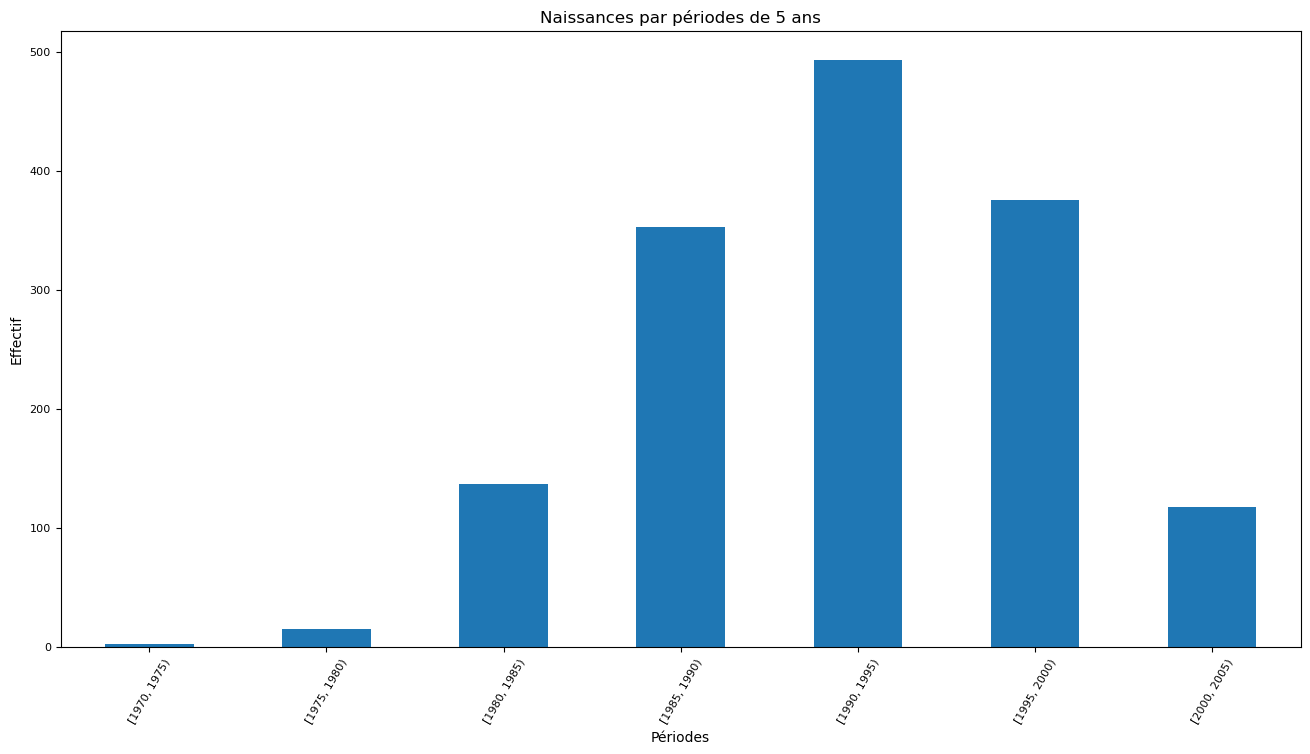

In [18]:
#Les naissances

#Convertir en datetime et extraire l'année de birthYear
df_r['birthYear'] = pd.to_datetime(df_r['birthYear'], errors='coerce')
df_r['year'] = df_r['birthYear'].dt.year

#Codage par période de 3 ans
l_5 = list(range(1970,2010,5))
print(l_5)

df_r['per_5'] = pd.cut(df_r['year'], l_5, right = False)
df_r['per_5'].head(5)

#Distribution des naissances par périodes de 5 ans
birth_per = df_r.groupby(by='per_5').size()
print(birth_per)

#Visualisation
ax = df_r.groupby(by='per_5').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de 5 ans')
plt.show()

['Q18142874', 'Q223341', 'Q840409', 'Q842146', 'Q771541', 'Q163628', 'Q207948', 'Q86919275', 'Q18515944', 'Q34852']


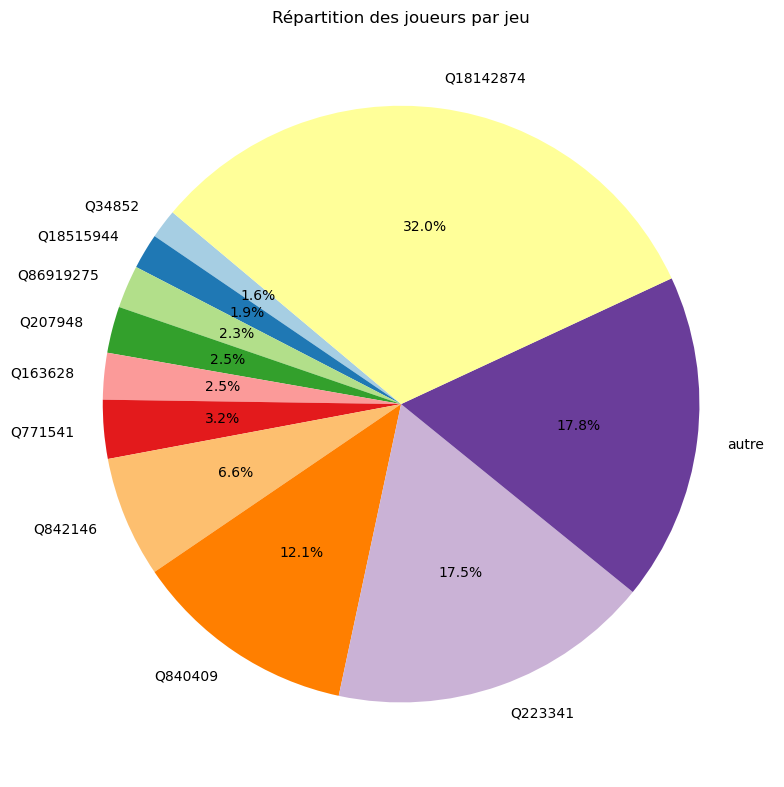

In [19]:
#Les jeux vidéos

#Mise au propre
def clean_id(s):
    if isinstance(s,str) and s.startswith('http'):
        return s.rsplit('/', 1) [-1]
    return s
df_r['game_clean'] = df_r['game'].apply(clean_id)

#codage
top10 = df_r['game_clean'].value_counts().head(10).index.tolist()
print(top10)

def codeGames(game):
    listGames = sorted(game.split(','))
    if game in top10:
        output = game
    else:
        output = 'autre'
    return output

codeGames('Q223341')
df_r['gameCode'] = df_r.apply(lambda x: codeGames(x['game_clean']), axis=1)

#Effectifs et fréquence

df_gameCode = df_r.groupby('gameCode').size()
df_gameCode = pd.DataFrame(df_gameCode.sort_values(ascending = True))
df_gameCode.columns=['effectif']

df_gameCode['frequence'] = (100 * df_gameCode['effectif'] \
                                   / df_gameCode['effectif'].sum()).round(2)

df_gameCode_sorted = df_gameCode.sort_values('effectif', ascending=True)

#Visualisation
plt.figure(figsize=(8, 8))
plt.pie(
    df_gameCode['effectif'],
    labels=df_gameCode.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title("Répartition des joueurs par jeu")
plt.tight_layout()
plt.show()

/var/folders/1v/zr1ngxfj6l161_c39xx9s9k80000gn/T/ipykernel_16825/2274533322.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_r.groupby(['per_5', 'gameCode'])


Text(0.5, 1.0, 'Répartition des jeux les plus populaires selon les années de naissance')

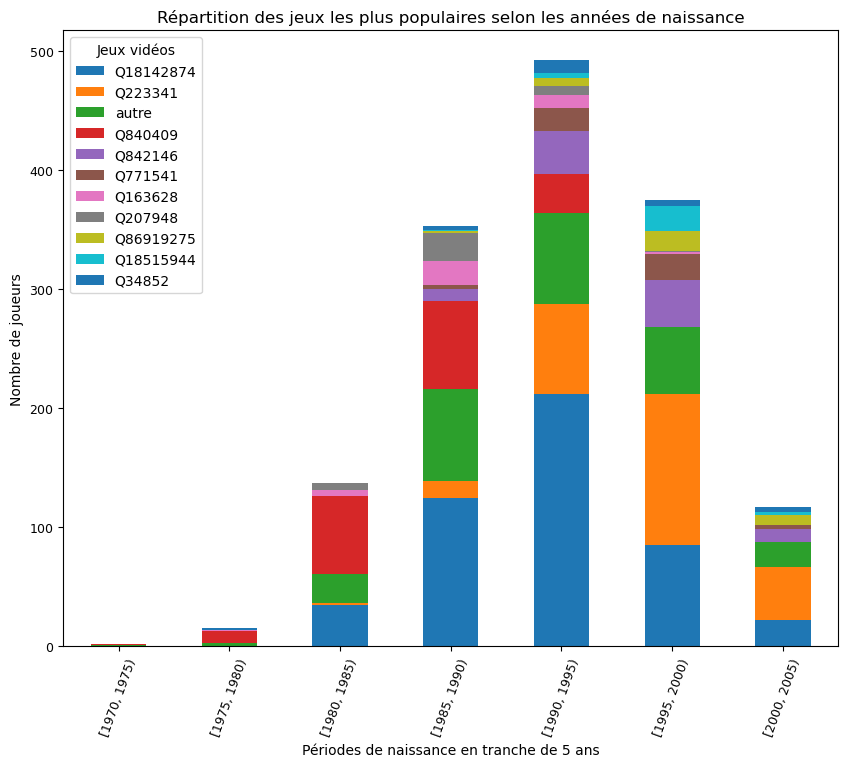

In [20]:
#Répartition des jeux selon l'âge
df_games_age = (
    df_r.groupby(['per_5', 'gameCode'])
        .size()
        .unstack(fill_value=0)
)

df_games_age = df_games_age[df_games_age.sum().sort_values(ascending=False).index]

data = df_games_age
ax = data.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(10,8))
ax.set_xlabel('Périodes de naissance en tranche de 5 ans')
ax.set_ylabel('Nombre de joueurs')
ax.legend(title = "Jeux vidéos")
plt.title('Répartition des jeux les plus populaires selon les années de naissance')